In [ ]:
a = [1, 2]
b = [4]
a += b
a

We can control the number of concurrent requests manually by using a semaphore to only do HTTP gets from 100 greenlets at a time. A semaphore works by making sure that only a certain number of coroutines can enter the context block at a time. As a result, we can launch all the greenlets that we need in order to fetch the URLs right away, but only 100 of them will be able to make HTTP calls at a time. Semaphores are one type of locking mechanism used a lot in various parallel code flows. By restricting the progression of your code based on various rules, locks can help you make sure that the various components of your program don’t interfere with each other.


In [ ]:
import time

def parallelizable_process():
    """though unclear how the cursor works here"""
    print("pp")

def queue_operation():
    print("queuing")

def asych_save_operation():
    """"""
    print("ready saving")
    time.sleep(5)
    print("saving done")

In [ ]:
def cursor(limit=4):
    i = 0
    while i < limit:
        print("cursor %s" % i)
        yield i
        i+= 1

In [ ]:
import asyncio

async def do_thing(i):
    print("do thing %s ..." % (i))
    await asyncio.sleep(1.0)
    return i

async def controller():
    i = 1
    result = await do_thing(i)
    print("controller %s " % (result))

# if asyncio._check_closed() and asyncio.is_running():
#     loop.
    
loop = asyncio.get_event_loop()
loop.run_until_complete(controller())
loop.close()


In [ ]:
from collections import deque

queue = deque()
size = 10

async def client_stage_batch(batch):
    """Handles sending the result to the server.
    Once the send is executed (not the successul completion)
    it will complete the future
    """
    future = asyncio.Future()
# ???????
    yield asyncio.ensure_future(slow_operation(future))


async def queue_side_handler(resultList):
    [queue.append(r) for r in resultList ]
    if len(queue >= size):
        result = await client_stage_batch(queue)
        # clear queue
        return result
    return True

# loop.run_until_complete(future)
# print(future.result())
# loop.close()


In [ ]:
async def processor_side_enque(resultList):
    """Sends the list of results to the queue from the processor
    The queue side returns a future which resolves after the 
    result list has been enqueued or the request has been sent to the 
    server (if the batch size has been reached)
    """
    result = await queue_side_handler(resultList)
    return result
    

# start an ipcontroller and cluster first

%%bash 
ipcluster start -n 2

In [ ]:

%cd twitteranalysis
import ipyparallel as ipp
# Connect to the cluster
rc = ipp.Client()

In [ ]:
%magic

# Example

In [ ]:
with rc[:].sync_imports():
    import numpy

In [ ]:
%px a = numpy.random.rand(2,2)


In [ ]:
%px numpy.linalg.eigvals(a)


In [ ]:
%%px --noblock --targets 1
print ('hi')


In [ ]:
%pxresult

In [ ]:
%%px --noblock --targets 0
print ('ho')


In [ ]:
%pxresult

In [ ]:
%%px --noblock
%cd twitteranalysis
from Servers import DatabaseServerGrumble as DSG 
j = DSG.main()

In [ ]:
%cd twitteranalysis

In [ ]:
%pxresult

In [ ]:
%%px --noblock --targets 1
%cd twitteranalysis

from Executables import process_user_descriptions_into_words as Runner
Runner.main()

In [ ]:
%pxresult

In [ ]:
import ipyparallel as ipp
rc = ipp.Client()



# lview = rc.load_balanced_view() 
# lview.block = True

# @lview.parallel()
# def start_db():
#     DSG.main()

# @lview.parallel()
# def run():
#     Runner.main()

# %%px --targets 1 

In [ ]:
rc.ids

In [ ]:

e1 = rc[0]
e2 = rc[1]
e1.apply(DSG.main())


In [ ]:
start_db()
print ('j')
run()

In [ ]:
%%px --noblock
print ('hi')



In [ ]:
%pxresult

# Based on quick and easy section

In [ ]:
#Run db in separate notebook



In [ ]:
%cd twitteranalysis
from Servers.DatabaseServerGrumble import main

In [ ]:
main()

# instrumenting to determine if running parallel



In [111]:
%cd twitteranalysis
import environment
import pandas as pd
from pandas import DataFrame, Series
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

client_send_file = "%s/client-send.csv" % environment.PROFILING_LOG_FOLDER_PATH
client_enque_file = "%s/client-enque.csv" % environment.PROFILING_LOG_FOLDER_PATH
server_receive_file = "%s/server-receive.csv" % environment.PROFILING_LOG_FOLDER_PATH
server_save_file = "%s/server-save.csv" % environment.PROFILING_LOG_FOLDER_PATH

(bookmark:twitteranalysis) -> /Users/adam/Dropbox/PainNarrativesLab/TwitterDataAnalysis
/Users/adam/Dropbox/PainNarrativesLab/TwitterDataAnalysis


## Load and process the log data

In [112]:

%cd twitteranalysis
import environment
import pandas as pd
from pandas import DataFrame, Series

# Load data
def load():
    d = pd.read_pickle(pickle)
    d.set_index('timestamps', inplace=True)
    print(len(d))
    return d

pickle = "%s/working-pickle" % environment.PROFILING_LOG_FOLDER_PATH

file_stems = ['client-send', 'client-enque', 'server-receive', 'server-save']
# def load(file_stems = file_stems):
series = []
columns = []
for f in file_stems:
    # make full file path
    path = "%s/%s.csv" % (environment.PROFILING_LOG_FOLDER_PATH, f)
    # read it in as a series
    s = pd.read_csv(path, squeeze=True)
    # NB, not converting to timestamp yet since easier to compare strings
    # s = s.apply(lambda x : pd.to_datetime(x))
    series.append(s)
    columns.append(f.replace('-', '_') )

d = [{ columns[i] : series[i]} for i in range(0, len(series))]

# create a unique list of timestamp strings
# these will serve as the index of the datafram
ts = pd.concat(series)
ts = set(ts.values)
print("%s unique timestamps" % len(ts))

# create the dataframe with the full index
# and named columns, but no data
data = DataFrame(index=ts, columns=columns)
data.reset_index(inplace=True)
# we have trouble with an upcoming apply step if the timestamps
# are the index or if the column is named index, so we rename it
data = data.rename({'index':'timestamps'}, axis=1)

# populate the dataframe
# This takes awhile.....
def ff(row, values, goodVal):
    if row.timestamps in values:
        return goodVal
    return 0

for i in range(0, len(columns)):
    name = columns[i]
    vs = series[i].values
    goodVal = i + 1
    data[name] = data.apply(lambda x : ff(x, vs, goodVal ), axis=1)

# Now that the comparison stuff is done,
# we can convert to actual datetimes
data.timestamps = data.timestamps.apply(lambda x: pd.to_datetime(x))

data.set_index('timestamps', inplace=True)
data.sort_index(inplace=True, axis=0)
data.reset_index(inplace=True)

# save the data to a file so we don't have to do the above
# every time
data.to_pickle(pickle)
print("Done")

(bookmark:twitteranalysis) -> /Users/adam/Dropbox/PainNarrativesLab/TwitterDataAnalysis
/Users/adam/Dropbox/PainNarrativesLab/TwitterDataAnalysis
4694 unique timestamps
Done


## Plot timestamps 

In [113]:
d = load()

4694


In [114]:
# consolidate at the seconds level
d = d.resample('S').mean()
len(d)

31

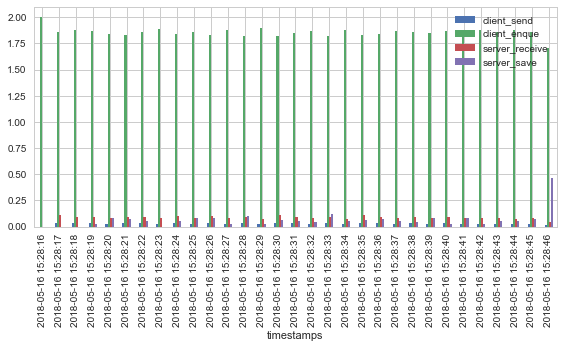

In [115]:
fig, axes = plt.subplots(figsize=(8,5))
d.plot(kind='bar', ax=axes)
fig.tight_layout()

# Expected times

In [116]:
# Load data
d = load()

4694


In [117]:
delta = d.index.max() - d.index.min()

In [118]:
delta.seconds

30

In [119]:
# numberUsersProcessed = 100
numberUsersProcessed = 4352
actualUsers = 1328927
pctActual = numberUsersProcessed / actualUsers

In [120]:
seconds_per_user = delta.seconds / numberUsersProcessed
seconds_per_user

0.006893382352941176

In [121]:
est_seconds = actualUsers * seconds_per_user
est_min = est_seconds / 60
est_min

152.68003216911762

In [122]:
est_hours = est_min / 60
est_hours

2.5446672028186272

5/16 3.21
    - change: changed get handler (queue flush) to coroutine
    - batch size of queue: 500
    - elapsed: 30 seconds
    - seconds/user: 0.0069
    - actual users 1328927
    - estimated minutes: 152.68
    - estimated hours: 2.54

5/15 8.08
    - change: changed server enque back to coroutine. Issue of the server not recording some recieved records remains fixed
    - batch size of queue: 500
    - elapsed: 30 seconds
    - seconds/user: 0.0069
    - actual users 1328927
    - estimated minutes: 152.68
    - estimated hours: 2.54


5/15 7.48
    - change: lock added to server side enque; changed from coroutine to async. this fixed the server not recording some recieved records
    - batch size of queue: 500
    - elapsed: 31 seconds
    - seconds/user: 0.0044
    - actual users 1328927
    - estimated minutes: 157.77
    - estimated hours: 2.63

5/15 6.27 
    - change: lock added back to sqlite writer
    - batch size of queue: 500
    - elapsed: 19 seconds
    - seconds/user: 0.0044
    - actual users 1328927
    - estimated minutes: 96.7
    - estimated hours: 1.61


5/15 10.37 
    - change: lock removed from sqlite writer; using single db
    - batch size of queue: 500
    - elapsed: 22 seconds
    - seconds/user: 0.005
    - actual users 1328927
    - estimated minutes: 111.97
    - estimated hours: 1.87

5/15 10.37 
    - change: lock added to sqlite writer
    - batch size of queue: 500
    - elapsed: 19 seconds
    - seconds/user: 0.0044
    - actual users 1328927
    - estimated minutes: 96.7
    - estimated hours: 1.61

5/15 10.37
    - batch size of queue: 500
    - elapsed: 20 seconds
    - seconds/user: 
    - actual users 1328927
    - estimated minutes: 101.787
    - estimated hours: 1.696

5/15 10.22
    - batch size of queue: 100
    - elapsed: 22 seconds
    - seconds/user: 0.0051
    - actual users 1328927
    - estimated minutes: 111.965
    - estimated hours: 1.866


5/14 7.00
    - batch size of queue: 10
    - elapsed: 34 seconds
    - seconds/user: 0.0078
    - actual users 1328927
    - estimated minutes: 173.037
    - estimated hours: 2.884


5/14 5.30
    - batch size of queue: 10
    - elapsed: 62 seconds
    - seconds/user: 0.014246
    - actual users 1328927
    - estimated minutes: 315.54
    - estimated hours: 5.26
    


In [ ]:
d = load()

In [ ]:
len(d[d.client_enque>0])

In [ ]:
len(d[d.server_save>0])

In [ ]:
len(d[d.client_send>0])

In [ ]:
len(d[d.server_receive>0])

In [ ]:
f = pd.read_csv(client_enque_file)
len(f)

In [ ]:
client_send = client_send.apply(lambda x : pd.to_datetime(x))

In [ ]:
client_enque = client_enque.apply(lambda x : pd.to_datetime(x))

In [ ]:
len(client_enque)

In [ ]:
client_enque[:4]

In [ ]:
client_send[:4]

In [ ]:
server_receive.columns[0]

In [ ]:
server_receive

In [ ]:
from profiling.OptimizingTools import log_start_stop

In [ ]:
import time

loc = '%s/test-log.csv' % environment.LOG_FOLDER_PATH

@log_start_stop(loc)
def test():
    print('j')
    time.sleep(5)
    print('k')



In [ ]:
test()

In [ ]:
# Then we load the data in and look to see if all the timestamps
# for any of the operations cluster in ways we don't want them to

In [ ]:
🐈  TwitterDataAnalysis $python Servers/DatabaseServerGrumble.py

Or, you know, we could just run them in separate ipython notebooks
since those are handled by separate kernels